In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\sohof\AppData\Local\Temp\ipykernel_12032\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

stations = session.query(Station).all()
for station in stations:
    print(station.name)

WAIKIKI 717.2, HI US
KANEOHE 838.1, HI US
KUALOA RANCH HEADQUARTERS 886.9, HI US
PEARL CITY, HI US
UPPER WAHIAWA 874.3, HI US
WAIMANALO EXPERIMENTAL FARM, HI US
WAIHEE 837.5, HI US
HONOLULU OBSERVATORY 702.2, HI US
MANOA LYON ARBO 785.2, HI US


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent = session.query(func.max(Measurement.date)).scalar()
print(most_recent)

2017-08-23


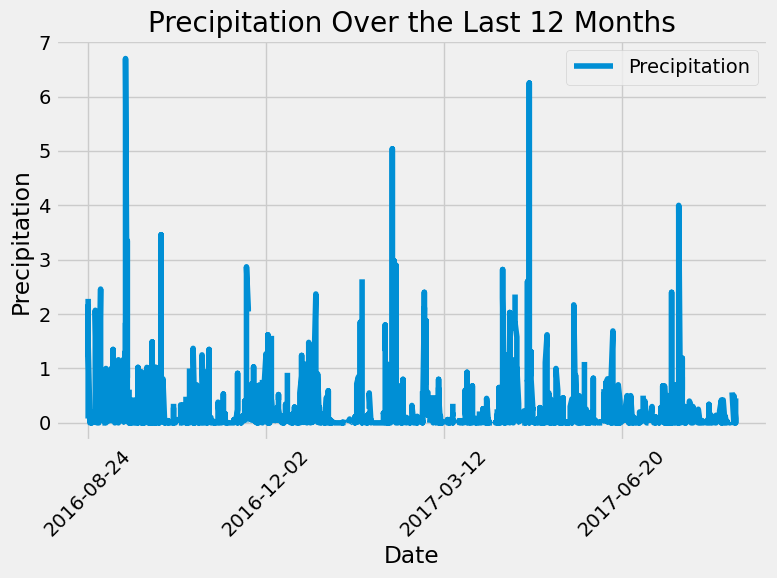

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = dt.datetime.strptime(most_recent, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_from = most_recent - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_from).\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])


# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values('date')


# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(precipitation_df['date'], precipitation_df['precipitation'], label='Precipitation')

# Format the x-axis
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))  # Limit to 5 labels

plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation Over the Last 12 Months')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [31]:
# Calculate summary statistics for the precipitation data
summary_stats = precipitation_df['precipitation'].describe()

# Display the summary statistics
summary_stats

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [34]:
# Design a query to calculate the total number of stations in the dataset
total_station = session.query(Station).count()
print(total_station)

9


In [36]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [38]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]


# temp data
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()

print(f"Most active station ID: {most_active_station_id}")
print(f"Lowest Temp: {lowest_temp}")
print(f"Highest Temp: {highest_temp}")
print(f"Average Temp: {average_temp}")


Most active station ID: USC00519281
Lowest Temp: 54.0
Highest Temp: 85.0
Average Temp: 71.66378066378067


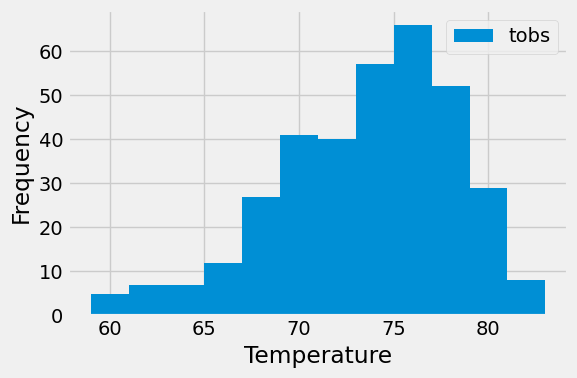

In [40]:
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_from).\
    order_by(Measurement.date).all()

temperature_df = pd.DataFrame(temperature_data, columns=['date', 'temperature'])

# Plot the data as a histogram
plt.figure(figsize=(6, 4))
plt.hist(temperature_df['temperature'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [44]:
# Close Session
session.close()